In this notebook I construct a simple CNN for my LSST simulations. These are in the /data/lsst_mocks_single directory. 

First, I construct training and validation sets by shuffling/splitting the data into training and testing sets with minimal pre-processing. I then build a simple convolutional neural network. I then evaluate the algorithm.

In [12]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/sarafinanance/anaconda/envs/datascience/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [26]:
n_images = 1000 # choose total number of images
n_test = int(n_images/5) # some fiducial fraction of images that you test on
n_train = int(n_images)*2 # some fiducial number of images that you train on

In [27]:
#import modules 

import numpy as np
import os
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

image_width = 45 # number of x-pixels, vary if different simulation set
image_height = 45 # number of y-pixels, vary if different simulation set

# create 2 3D empty arrays to append lensed and unlensed images to, respectively
images = np.empty(shape=[0,image_width,image_height]) 
images2 = np.empty(shape=[0,image_width,image_height])

# filename to lensed and unlensed outputs
# [ADJUST PATH ON YOUR MACHINE TO DOWNLOAD DIRECTORY]
filename = os.listdir(os.getcwd()+"/data_of_lsst/lsst_mocks_single/lensed_outputs/0")
filename2 = os.listdir(os.getcwd()+"/data_of_lsst/lsst_mocks_single/unlensed_outputs/0")

# Import images and ignore DS.store file, as this throws an error
for file in filename[:n_images]:
    if not file.startswith('.'):
        try:
            image_file = get_pkg_data_filename("data_of_lsst/lsst_mocks_single/lensed_outputs/0/" + file)
            image_data = fits.getdata(image_file, ext=0, ignore_missing_end=True, padding=False)
            images = np.concatenate((images, [image_data]))
        except OSError as err:
            print('This file sucks %s' % (image_file))

            
print ("Done !")

for file in filename2[:n_images]:
    if not file.startswith('.'):
        try:
            image_file = get_pkg_data_filename("data_of_lsst/lsst_mocks_single/unlensed_outputs/0/" + file)
            image_data = fits.getdata(image_file, ext=0, ignore_missing_end=True, padding=False)
            images2 = np.concatenate((images2, [image_data]))
        except OSError as err:
            print('This file sucks %s' % (image_file))

print ("Done !")

# append downloaded images to empty 3D arrays
lensed_output_0 = images
unlensed_output_0 = images2

Done !
Done !


Creating training and validation sets

In [28]:
# Remove 'NaN' from datasets, as some simulations included NaN variables
lensed_output_0 = np.where(np.isfinite(lensed_output_0), lensed_output_0, 0)
unlensed_output_0 = np.where(np.isfinite(unlensed_output_0), lensed_output_0, 0)

In [29]:
import random 
from keras.utils import np_utils

# Set aside data for testing
# Concatenate lensed and unlensed systems to create an ndarray twice the size of n_images
training_data= np.concatenate((lensed_output_0, unlensed_output_0), axis=0)
training_labels = np.concatenate((np.ones(n_images), np.zeros(n_images)), axis=0)

# Combine, shuffle, and randomize data
combined = list(zip(training_data,training_labels))
random.shuffle(combined)
training_data, training_labels = zip(*combined)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

# Create training set and labels using some portion of the data (can be adjusted as needed)
X_train = training_data[:int(n_images)*2]
y_train = training_labels[:int(n_images)*2]
X_test = training_data[1600:n_train] #this starting integer value should be adjusted for the n_images you include
y_test = training_labels[1600:n_train]

In [30]:
# We use the full set for training
x = X_train.reshape((-1,1,45,45))
y = y_train.reshape((-1,1))
# We reuse training set as our validation set
xval = X_test.reshape((-1,1, 45, 45))
yval = y_test.reshape((-1,1))

In [31]:
# Clipping and scaling parameters applied to the data as preprocessing
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(x == 100)
mask_val = np.where(xval == 100)

x[mask] = 0
xval[mask_val] = 0

# Simple clipping and rescaling the images
x = np.clip(x, vmin, vmax)/vmax * scale
xval = np.clip(xval, vmin, vmax)/vmax * scale 

x[mask] = 0
xval[mask_val] = 0

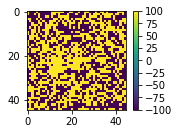

In [32]:
import matplotlib.pyplot as plt

#Illustration of a lens in one color band
im = x[0].T
plt.subplot(221)
plt.imshow(im[:,:,0]); plt.colorbar()

# Classic CNN

In [33]:
#import modules
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D

In [34]:
nb_classes = 2

# input data dimensions
data_len = 45

# reshape X data
img_cols = 45
img_rows = 45
input_shape=(img_cols, img_rows, 1)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [35]:
# Sequential Model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 43, 43, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6402      
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total para

In [36]:
# Train
batch_size = 50
nb_epoch = 10
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, 
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 2000 samples, validate on 400 samples
Epoch 1/10
 - 2s - loss: 7.8093 - acc: 0.5030 - val_loss: 7.6962 - val_acc: 0.5200
Epoch 2/10
 - 2s - loss: 8.0078 - acc: 0.5000 - val_loss: 7.6962 - val_acc: 0.5200
Epoch 3/10
 - 2s - loss: 8.0078 - acc: 0.5000 - val_loss: 7.6962 - val_acc: 0.5200
Epoch 4/10
 - 2s - loss: 7.8368 - acc: 0.5005 - val_loss: 7.6962 - val_acc: 0.5200
Epoch 5/10
 - 2s - loss: 7.9735 - acc: 0.5000 - val_loss: 8.1016 - val_acc: 0.4825
Epoch 6/10
 - 2s - loss: 2.6428 - acc: 0.5030 - val_loss: 1.8156 - val_acc: 0.5225
Epoch 7/10
 - 2s - loss: 1.7668 - acc: 0.5155 - val_loss: 1.7612 - val_acc: 0.5200
Epoch 8/10
 - 2s - loss: 1.5129 - acc: 0.4920 - val_loss: 1.6412 - val_acc: 0.5175
Epoch 9/10
 - 2s - loss: 1.1664 - acc: 0.4865 - val_loss: 1.2056 - val_acc: 0.4875
Epoch 10/10
 - 2s - loss: 0.9548 - acc: 0.4845 - val_loss: 0.7155 - val_acc: 0.4775
Test score: 0.7154523801803588
Test accuracy: 0.4775


In [38]:
list(zip(model.predict(X_test[:20]).T[1], model.predict_classes(X_test[:20]), y_test[0:20]))

[(0.4282581, 0, 0.0),
 (0.5922831, 1, 1.0),
 (0.5315946, 1, 0.0),
 (0.47931823, 0, 1.0),
 (0.6120104, 1, 1.0),
 (0.49616262, 0, 0.0),
 (0.6927005, 1, 0.0),
 (0.4323499, 0, 1.0),
 (0.6703788, 1, 1.0),
 (0.63346016, 1, 0.0),
 (0.4755623, 0, 1.0),
 (0.4196455, 0, 1.0),
 (0.51789975, 1, 1.0),
 (0.53577137, 1, 1.0),
 (0.6384305, 1, 0.0),
 (0.52527916, 1, 1.0),
 (0.39432463, 0, 1.0),
 (0.6047278, 1, 0.0),
 (0.5551027, 1, 1.0),
 (0.50655794, 1, 1.0)]

0
0.0


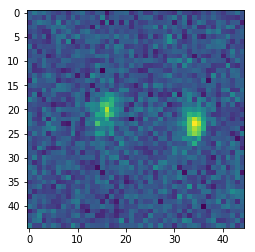

1
1.0


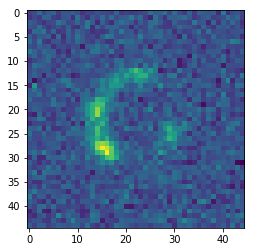

2
0.0


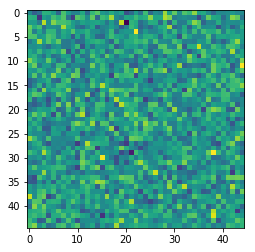

3
1.0


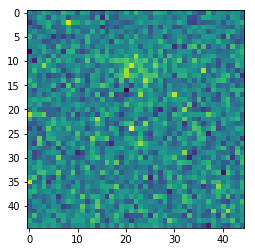

4
1.0


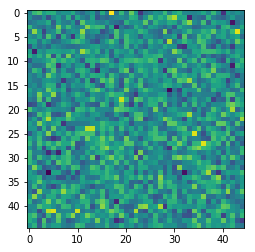

5
0.0


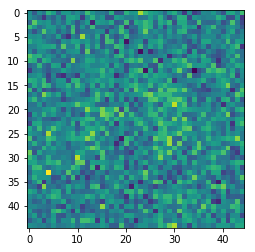

6
0.0


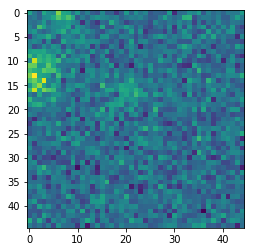

7
1.0


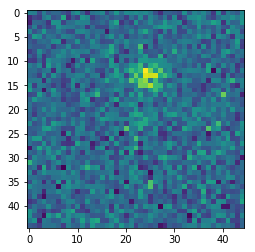

8
1.0


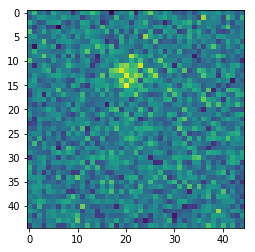

9
0.0


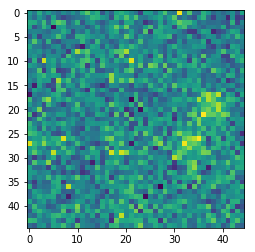

10
1.0


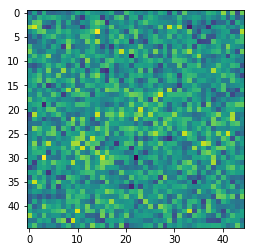

11
1.0


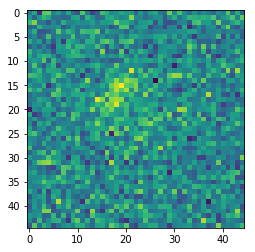

12
1.0


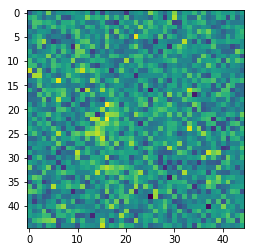

13
1.0


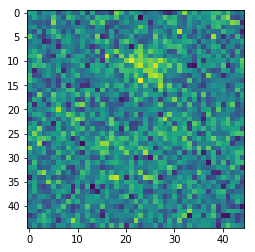

14
0.0


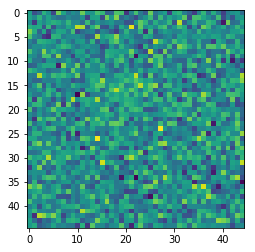

15
1.0


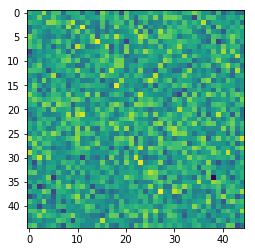

16
1.0


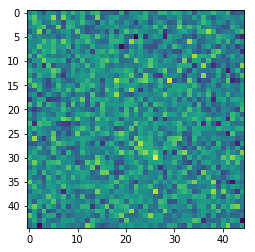

17
0.0


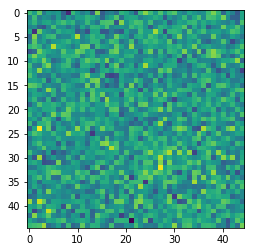

18
1.0


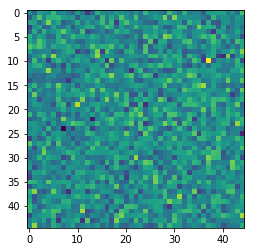

19
1.0


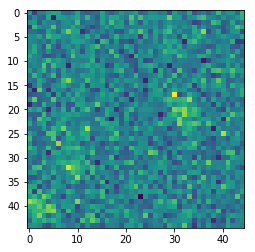

20
0.0


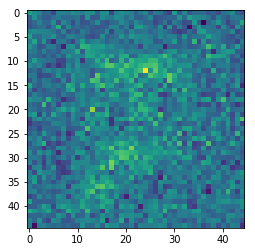

21
1.0


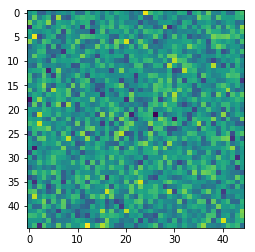

22
1.0


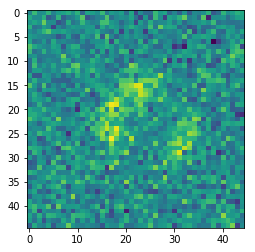

23
1.0


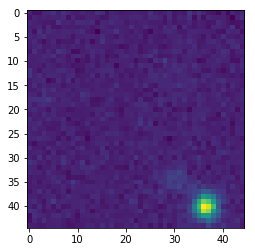

24
0.0


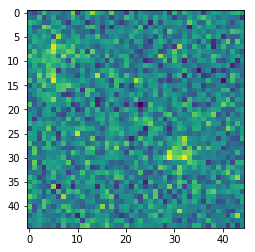

25
1.0


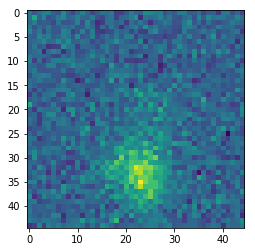

26
1.0


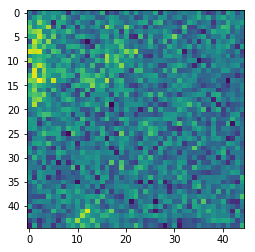

27
0.0


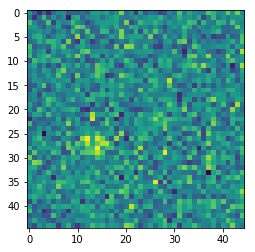

28
1.0


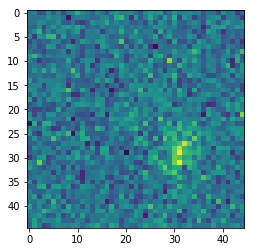

29
1.0


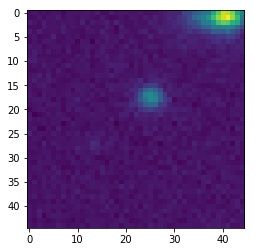

30
0.0


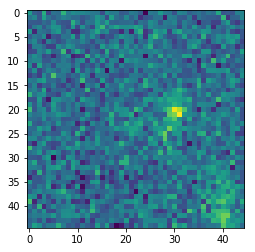

31
1.0


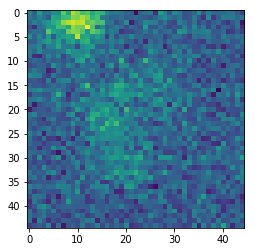

32
1.0


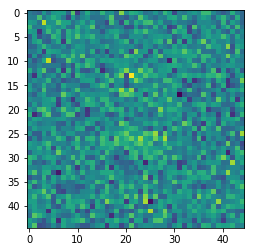

33
0.0


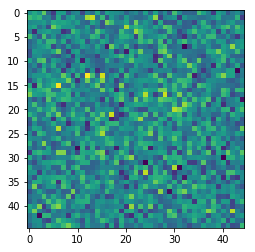

34
0.0


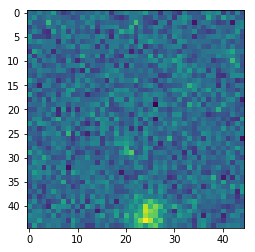

35
0.0


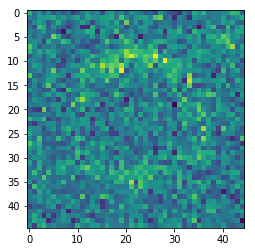

36
1.0


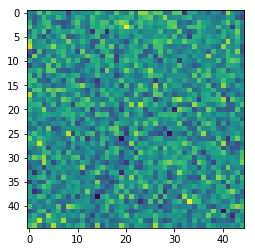

37
0.0


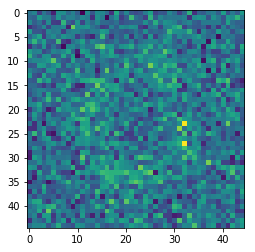

38
1.0


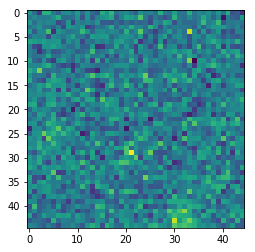

39
0.0


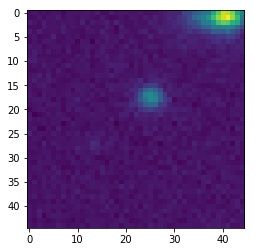

40
1.0


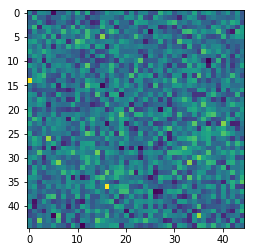

41
1.0


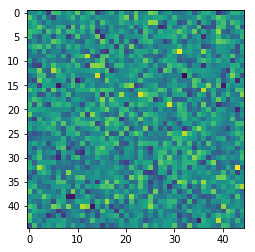

42
0.0


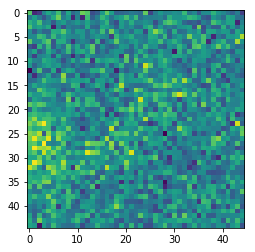

43
1.0


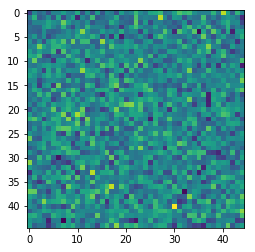

44
0.0


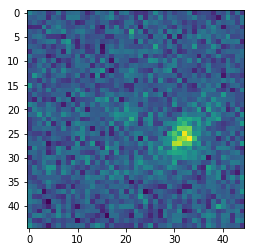

45
0.0


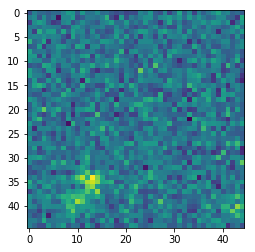

46
1.0


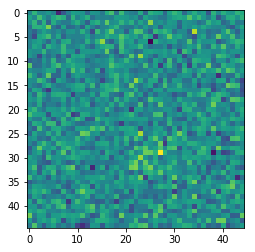

47
1.0


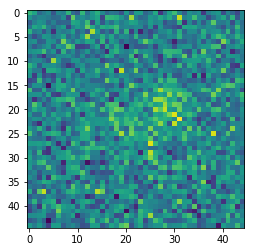

48
1.0


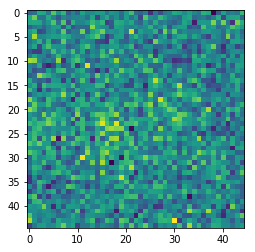

49
1.0


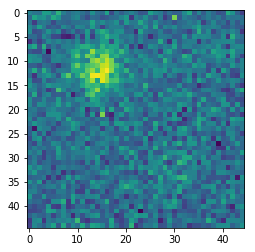

50
0.0


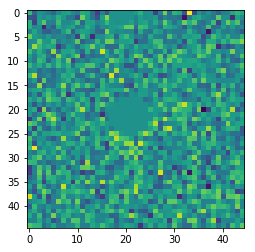

51
0.0


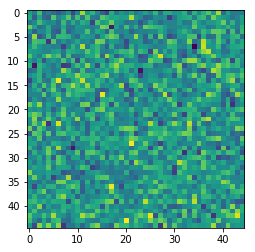

52
0.0


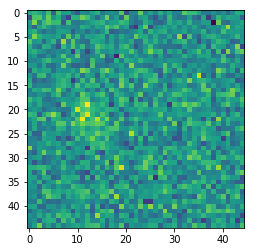

53
0.0


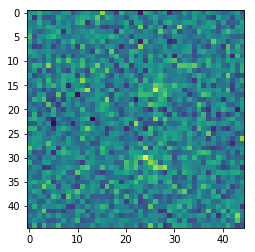

54
0.0


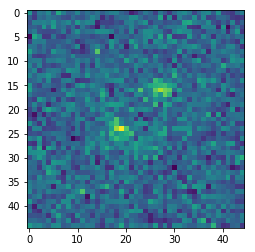

55
1.0


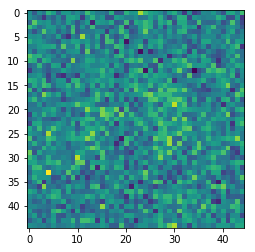

56
0.0


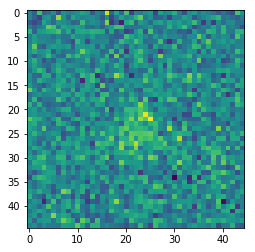

57
1.0


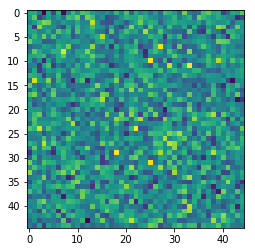

58
1.0


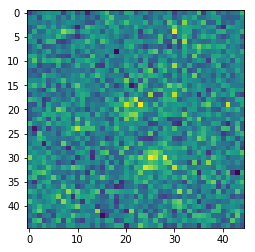

59
0.0


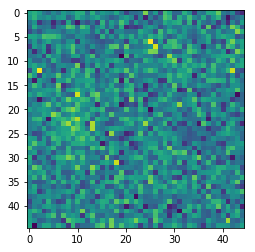

60
0.0


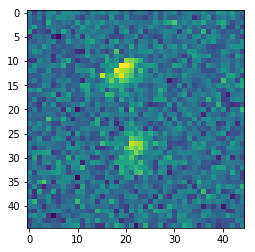

61
1.0


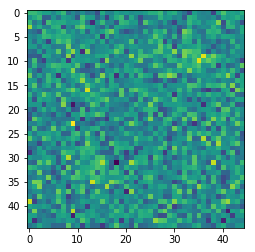

62
1.0


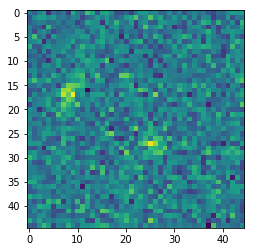

63
1.0


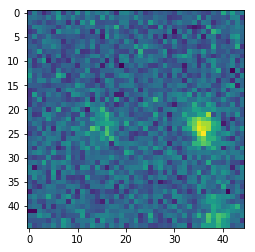

64
0.0


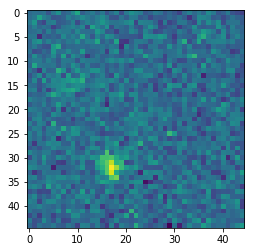

65
0.0


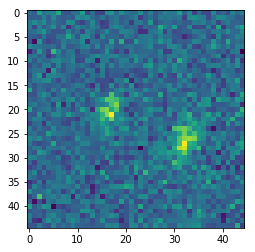

66
0.0


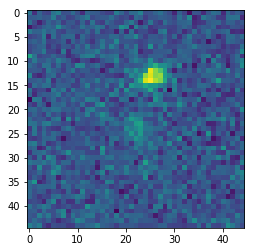

67
1.0


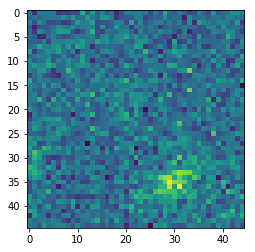

68
1.0


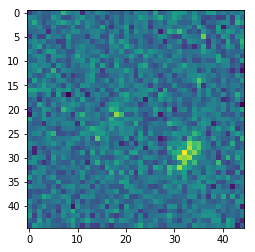

69
1.0


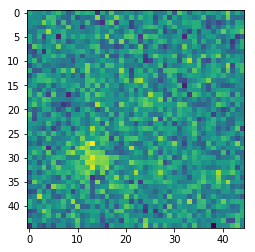

70
1.0


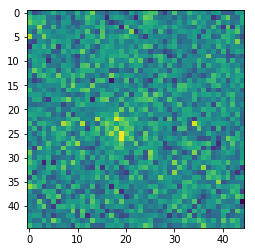

71
1.0


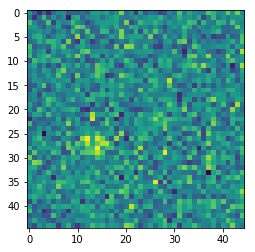

72
1.0


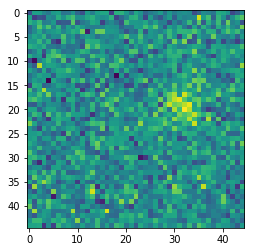

73
1.0


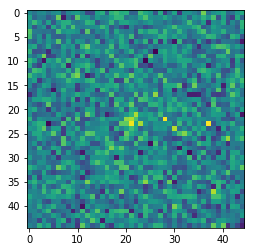

74
1.0


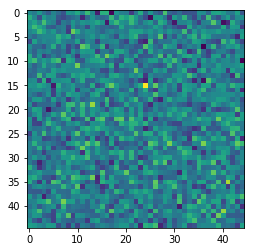

75
1.0


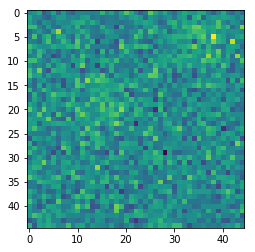

76
1.0


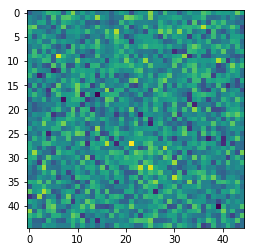

77
1.0


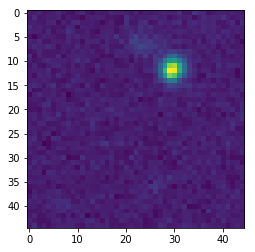

78
0.0


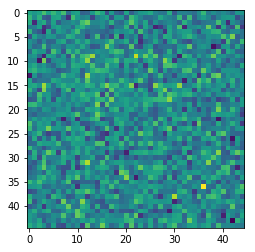

79
1.0


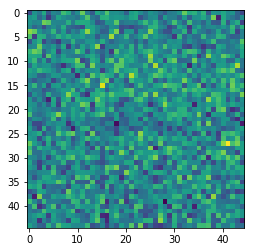

80
1.0


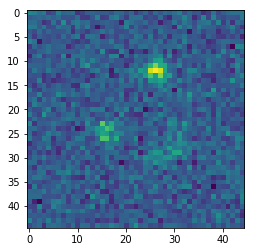

81
0.0


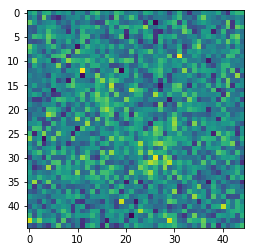

82
1.0


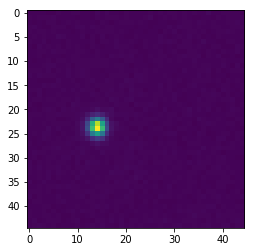

83
0.0


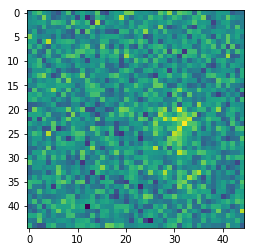

84
0.0


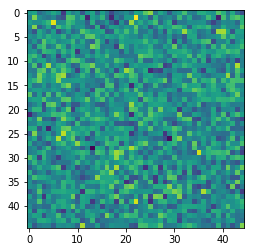

85
0.0


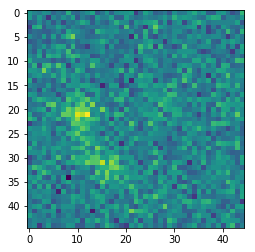

86
0.0


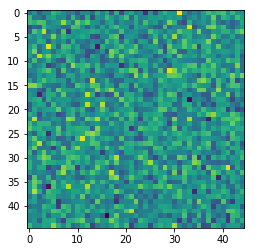

87
1.0


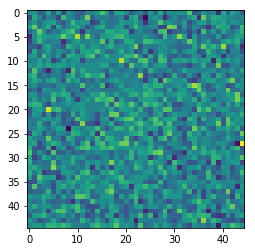

88
0.0


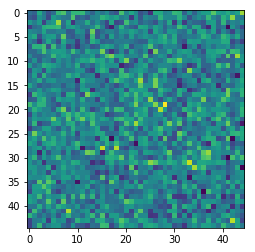

89
1.0


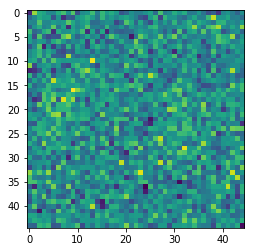

90
0.0


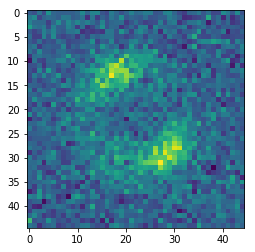

91
1.0


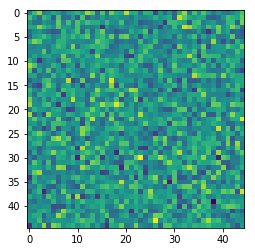

92
1.0


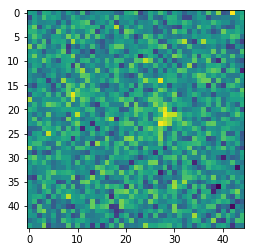

93
0.0


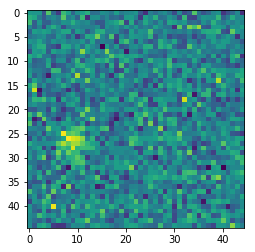

94
0.0


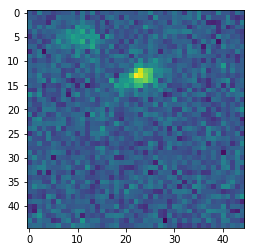

95
1.0


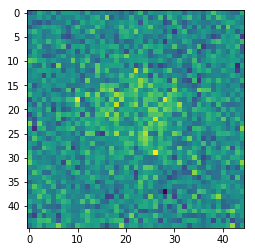

96
0.0


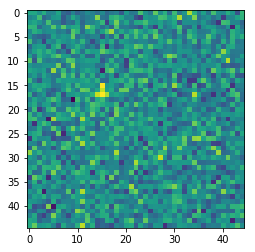

97
0.0


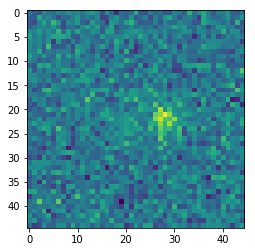

98
0.0


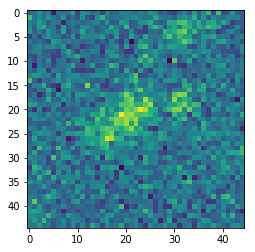

99
0.0


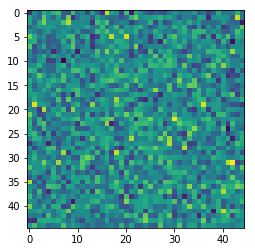

100
1.0


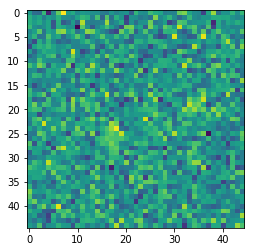

101
0.0


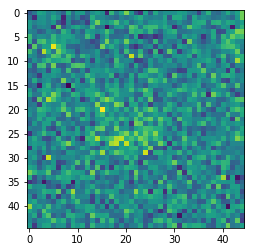

102
0.0


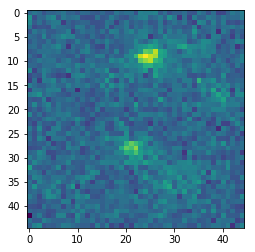

103
0.0


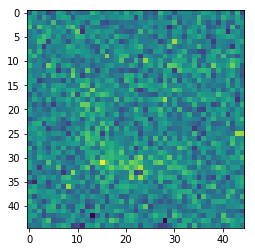

104
1.0


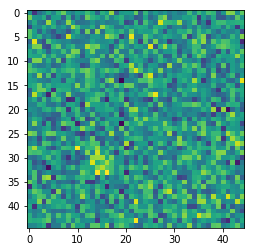

105
0.0


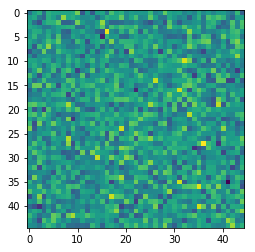

106
1.0


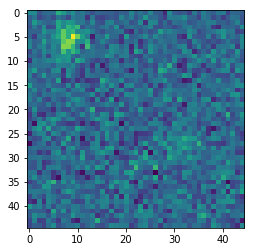

107
0.0


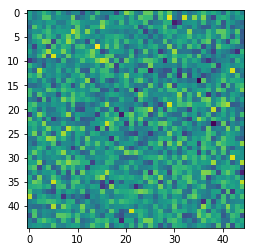

108
0.0


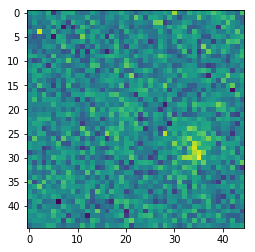

109
1.0


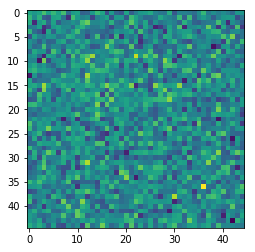

110
1.0


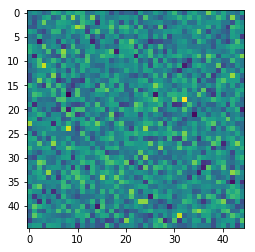

111
0.0


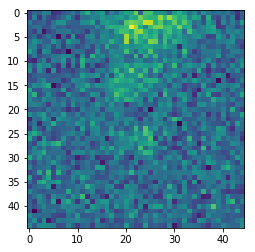

112
1.0


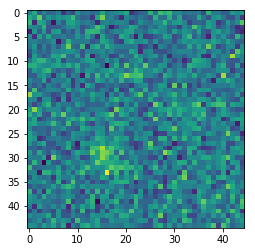

113
1.0


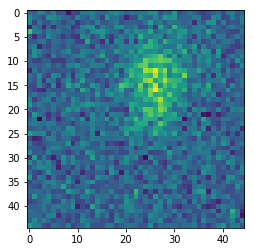

114
1.0


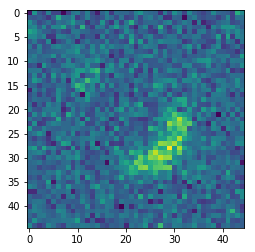

115
1.0


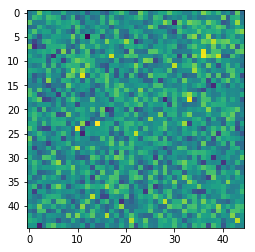

116
0.0


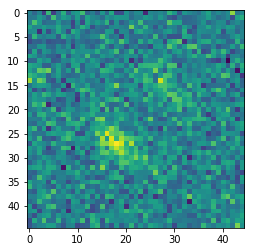

117
0.0


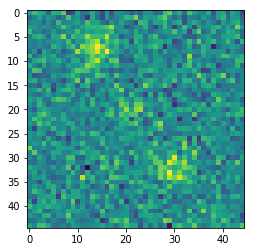

118
0.0


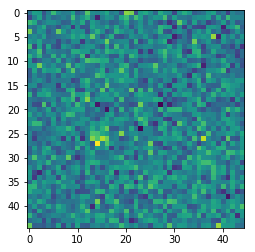

119
0.0


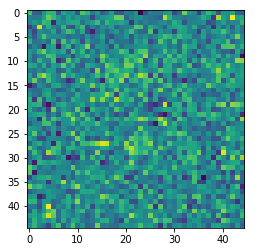

120
0.0


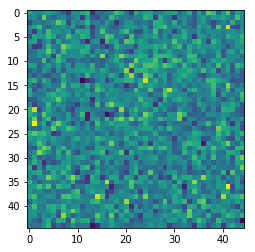

121
0.0


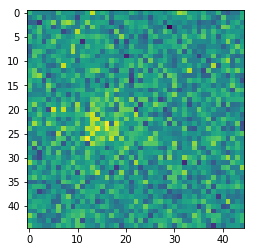

122
1.0


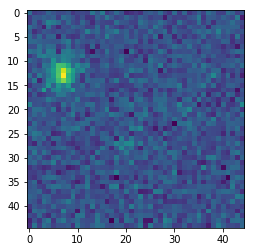

123
0.0


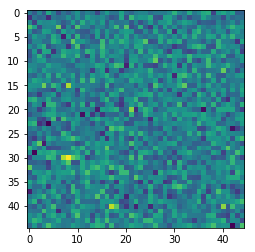

124
0.0


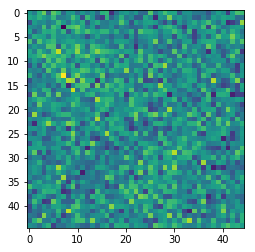

125
1.0


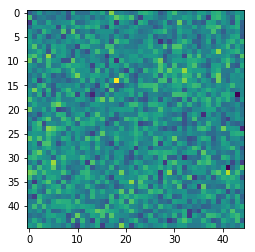

126
1.0


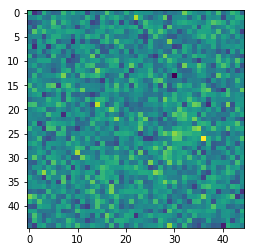

127
0.0


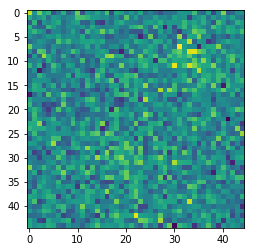

128
1.0


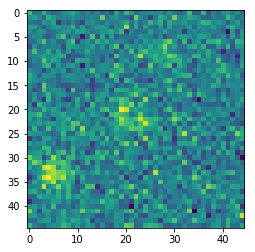

129
1.0


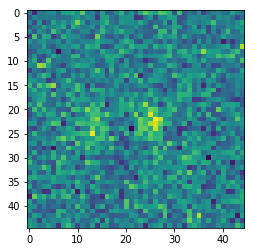

130
1.0


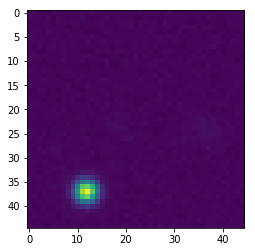

131
1.0


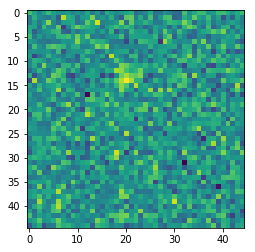

132
1.0


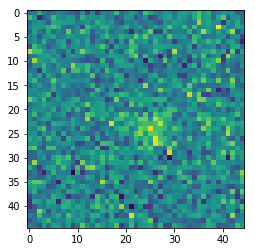

133
1.0


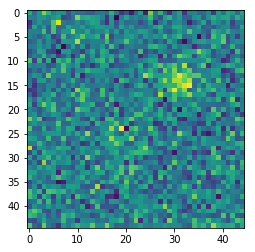

134
1.0


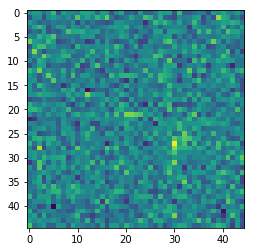

135
0.0


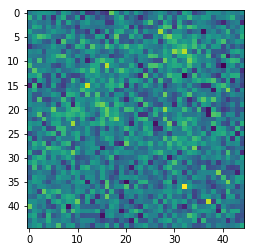

136
1.0


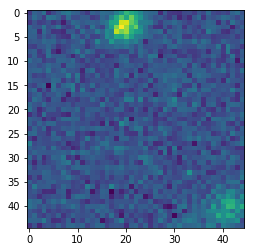

137
1.0


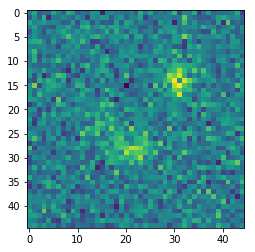

138
1.0


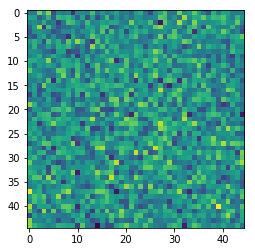

139
0.0


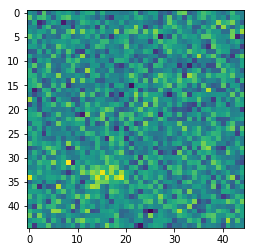

140
1.0


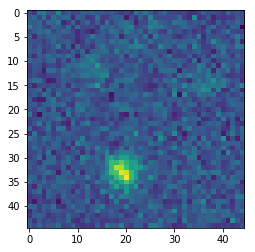

141
0.0


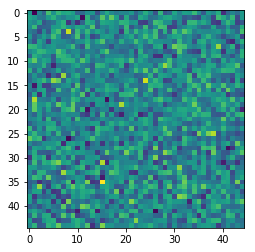

142
0.0


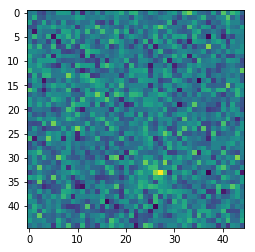

143
1.0


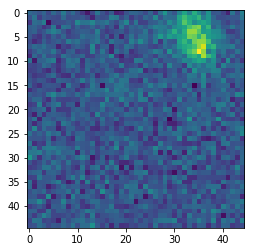

144
0.0


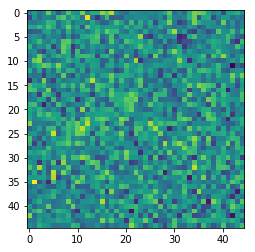

145
1.0


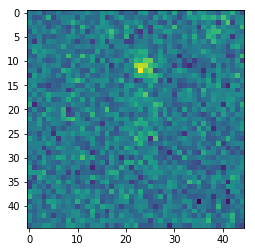

146
1.0


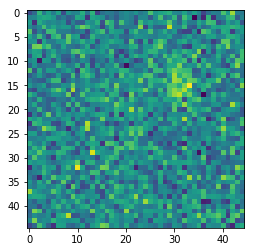

147
0.0


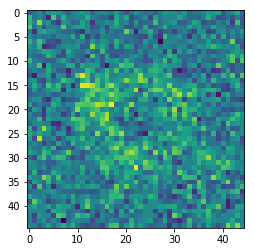

148
1.0


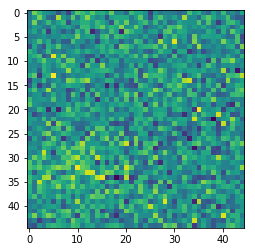

149
0.0


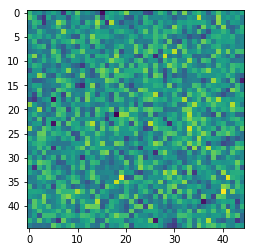

150
1.0


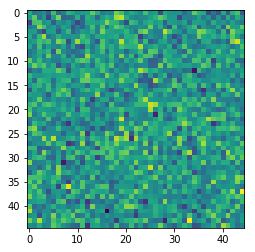

151
1.0


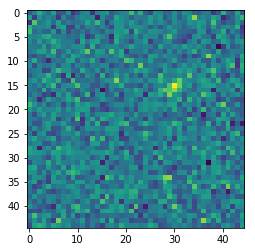

152
0.0


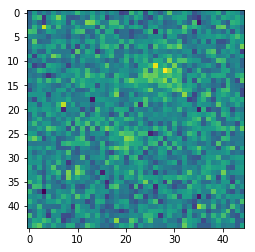

153
0.0


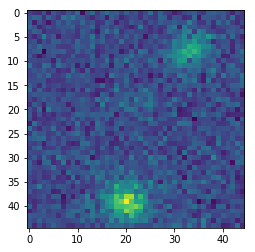

154
0.0


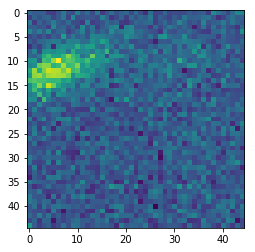

155
0.0


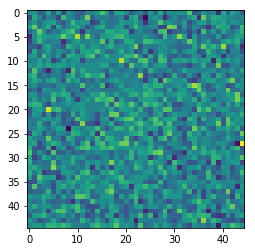

156
1.0


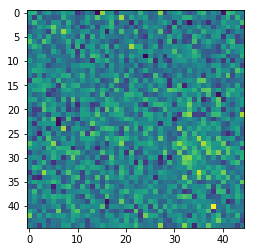

157
1.0


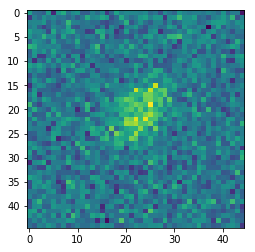

158
1.0


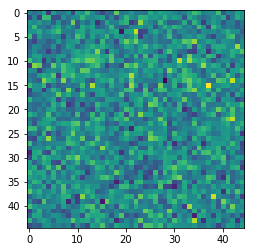

159
1.0


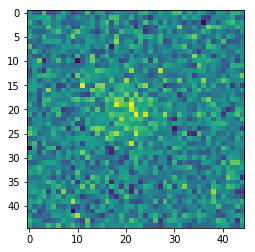

160
1.0


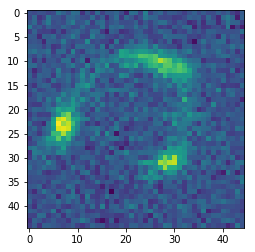

161
0.0


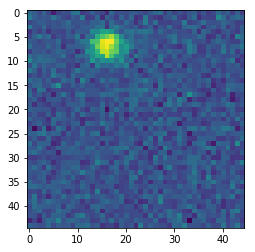

162
0.0


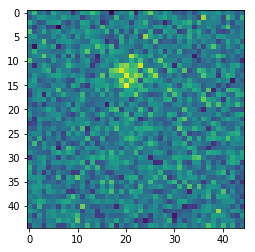

163
0.0


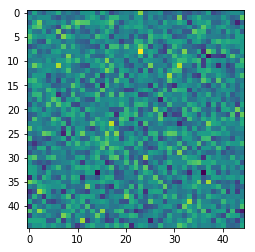

164
0.0


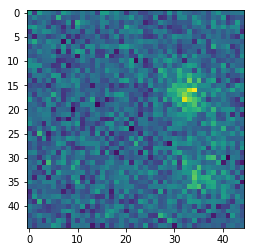

165
1.0


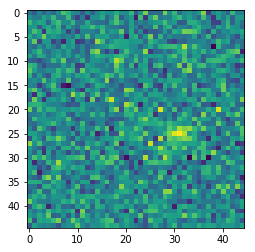

166
1.0


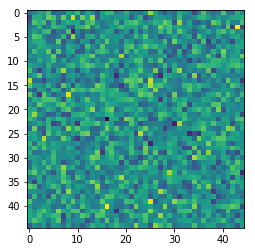

167
1.0


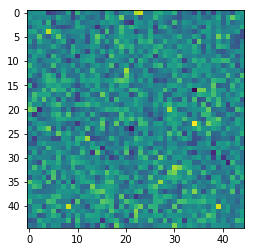

168
0.0


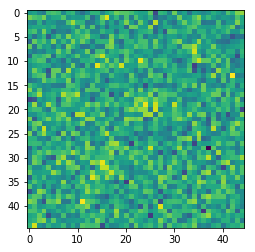

169
1.0


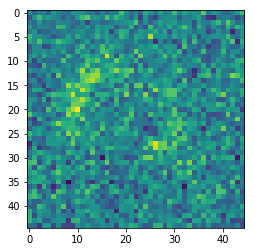

170
1.0


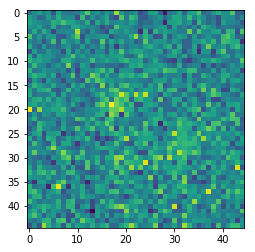

171
1.0


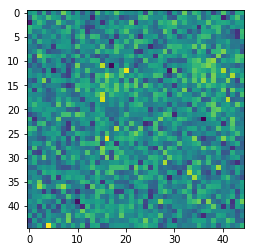

172
0.0


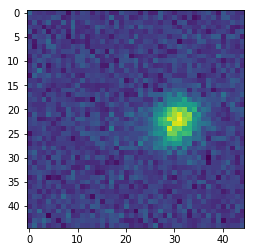

173
1.0


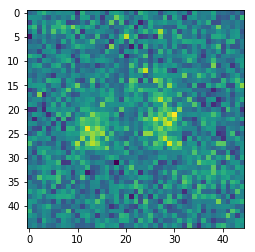

174
0.0


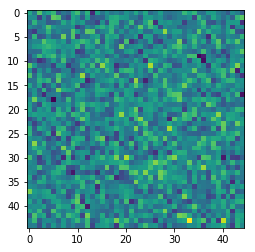

175
0.0


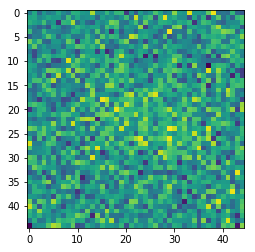

176
0.0


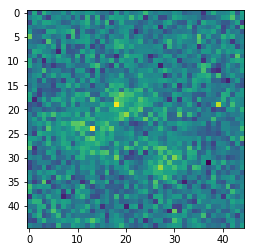

177
0.0


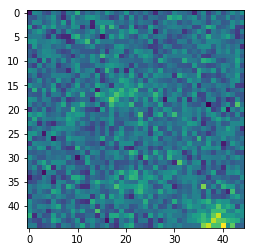

178
0.0


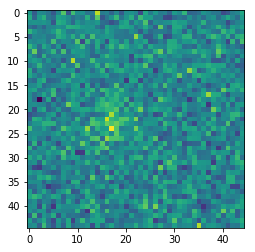

179
0.0


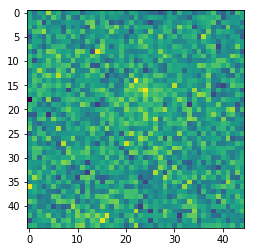

180
0.0


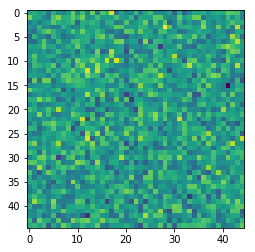

181
0.0


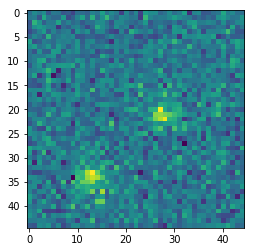

182
0.0


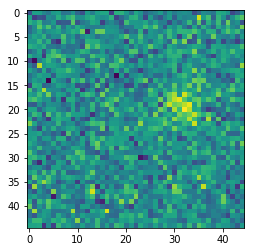

183
1.0


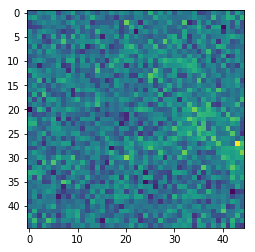

184
0.0


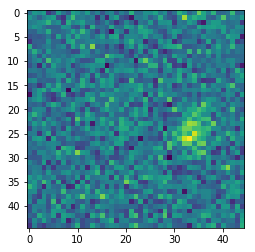

185
0.0


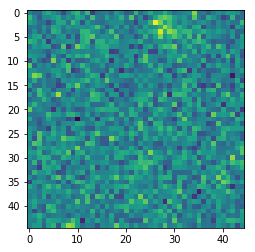

186
1.0


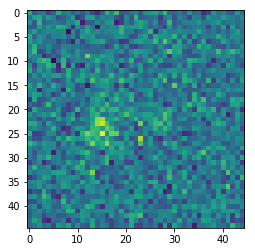

187
1.0


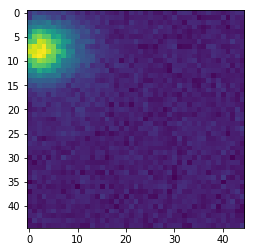

188
0.0


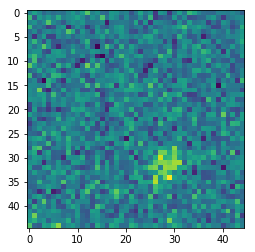

189
0.0


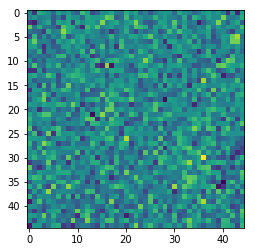

190
0.0


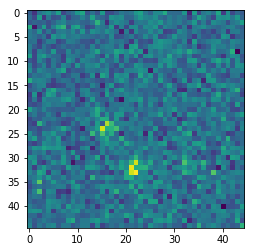

191
0.0


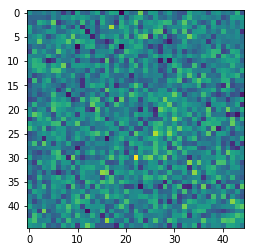

192
0.0


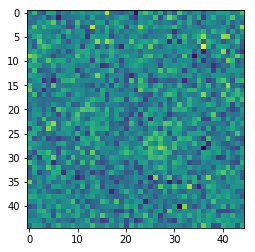

193
1.0


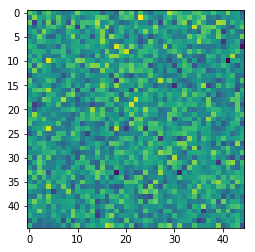

194
1.0


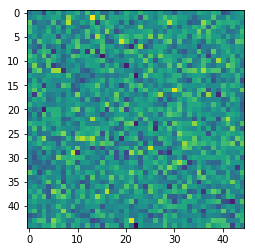

195
0.0


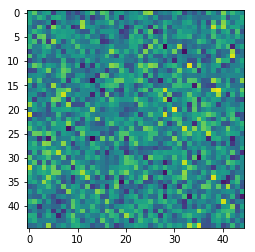

196
0.0


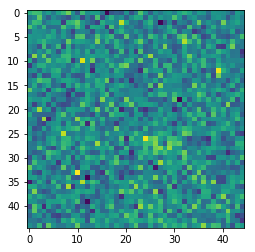

197
0.0


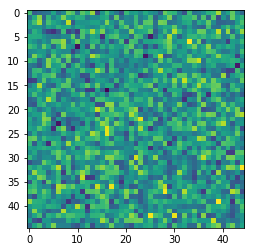

198
1.0


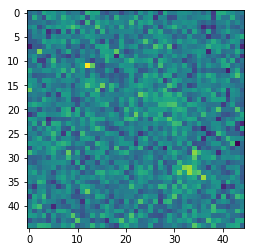

199
0.0


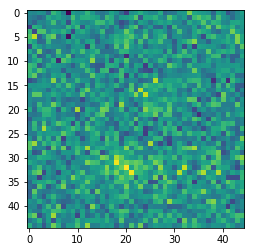

200
1.0


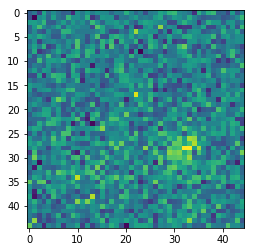

201
0.0


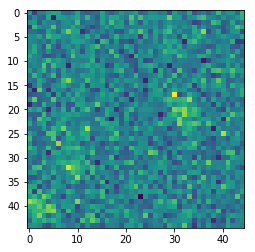

202
0.0


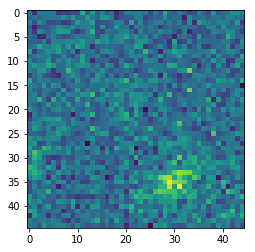

203
1.0


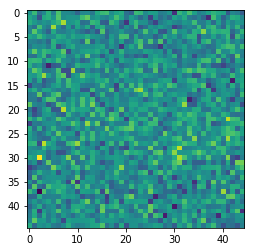

204
1.0


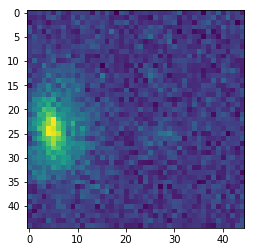

205
0.0


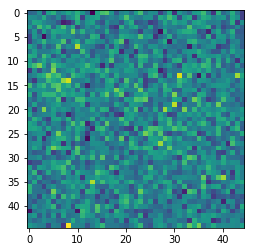

206
1.0


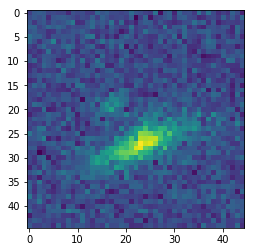

207
1.0


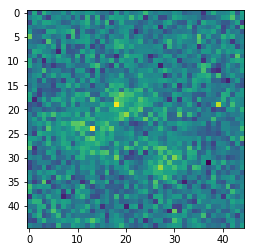

208
1.0


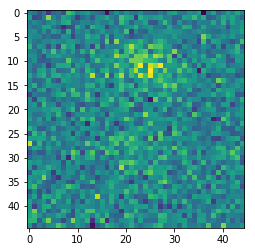

209
1.0


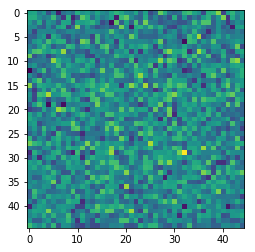

210
1.0


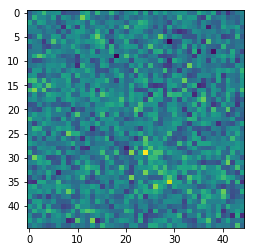

211
1.0


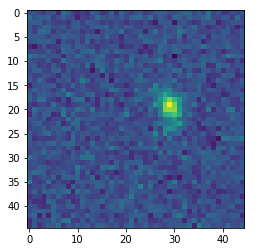

212
1.0


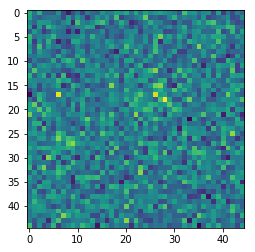

213
0.0


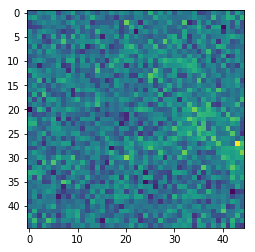

214
0.0


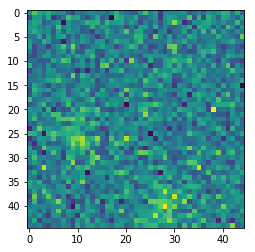

215
1.0


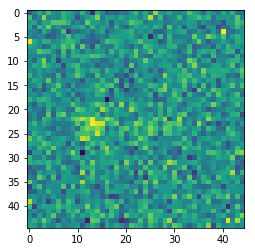

216
1.0


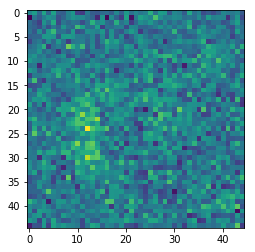

217
1.0


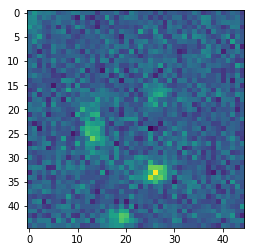

218
1.0


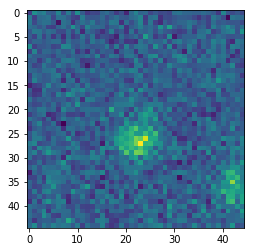

219
0.0


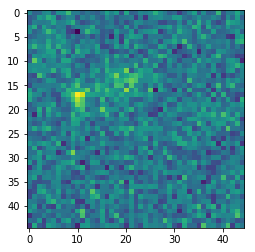

220
1.0


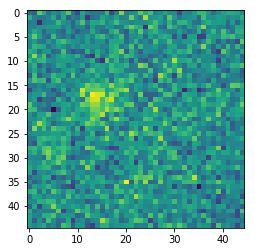

221
1.0


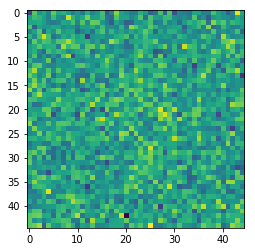

222
1.0


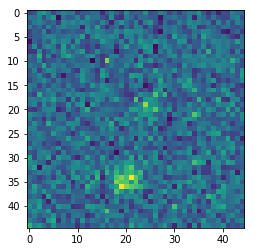

223
0.0


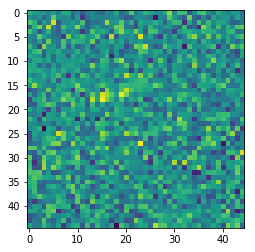

224
0.0


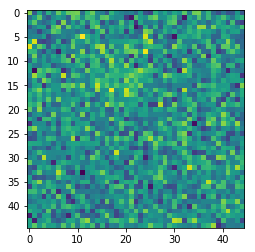

225
1.0


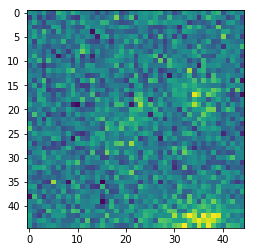

226
1.0


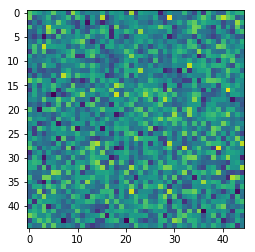

227
0.0


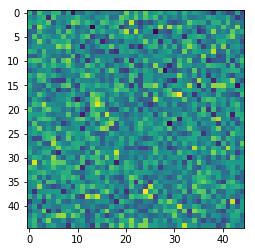

228
1.0


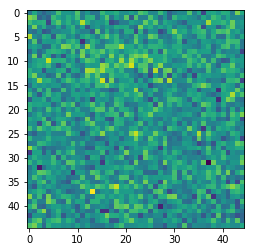

229
1.0


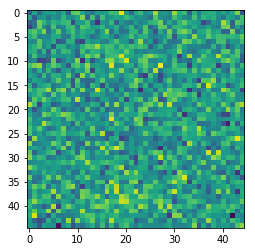

230
0.0


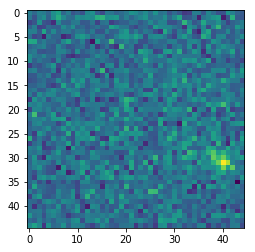

231
1.0


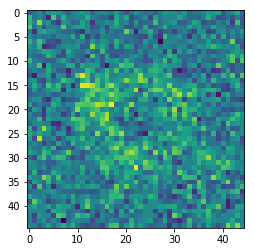

232
1.0


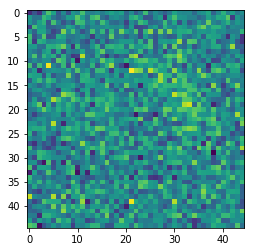

233
1.0


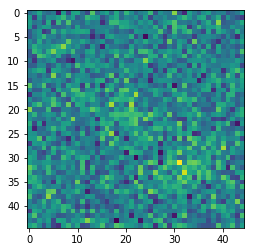

234
0.0


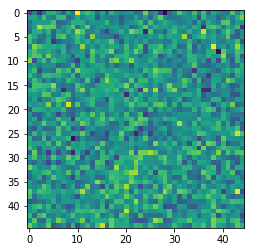

235
0.0


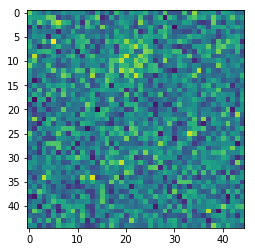

236
0.0


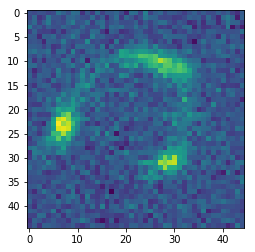

237
0.0


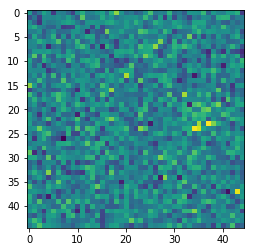

238
0.0


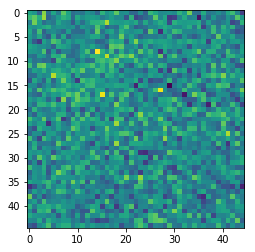

239
1.0


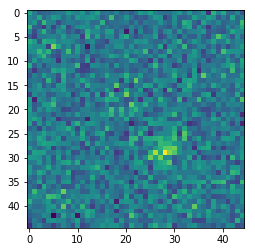

240
0.0


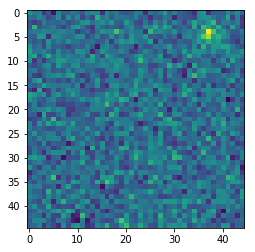

241
1.0


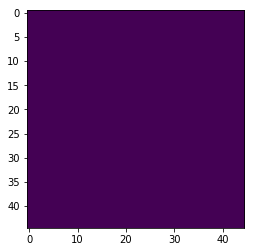

242
0.0


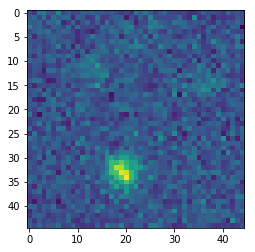

243
0.0


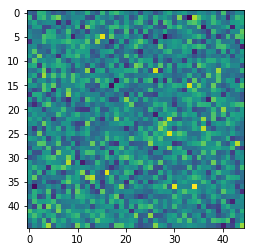

244
0.0


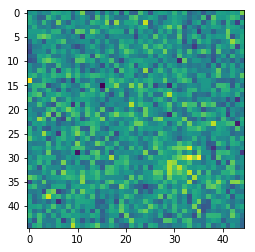

245
0.0


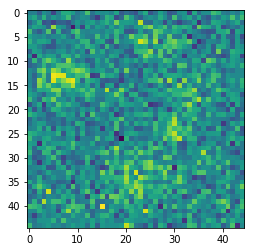

246
1.0


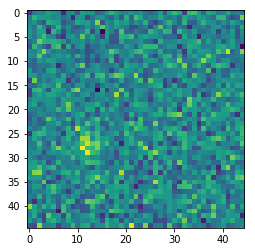

247
1.0


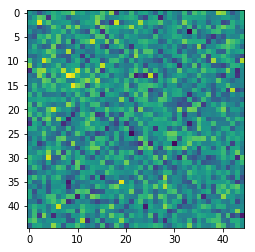

248
0.0


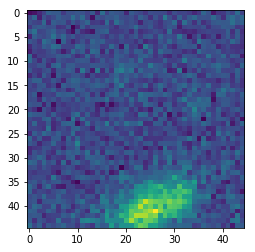

249
0.0


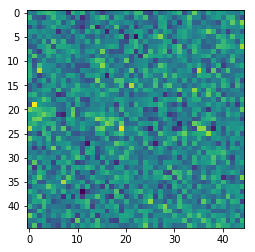

250
0.0


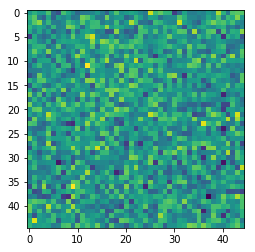

251
1.0


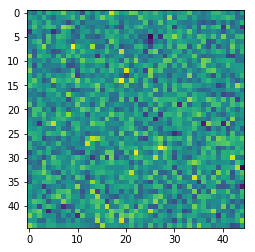

252
1.0


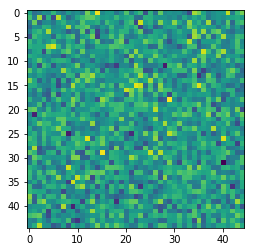

253
0.0


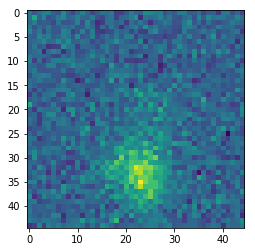

254
0.0


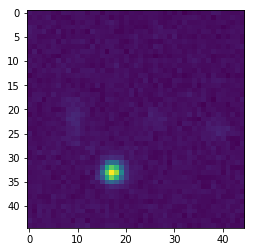

255
0.0


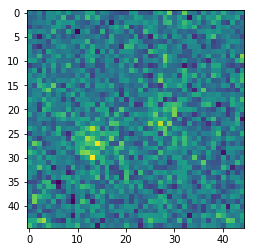

256
1.0


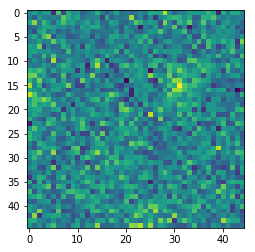

257
1.0


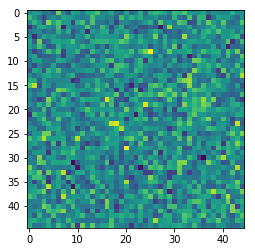

258
1.0


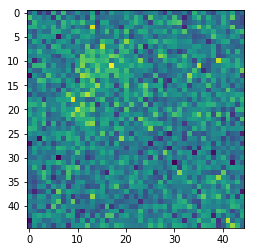

259
1.0


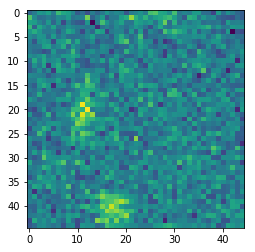

260
1.0


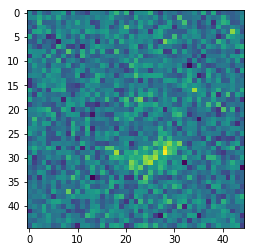

261
0.0


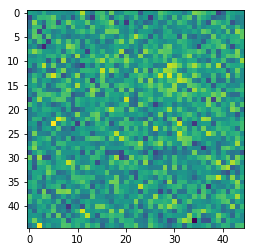

262
0.0


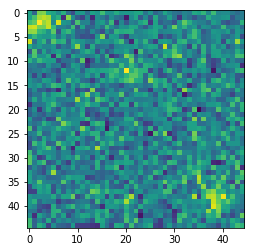

263
0.0


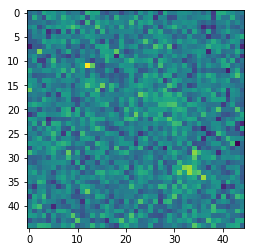

264
1.0


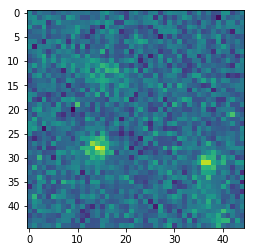

265
1.0


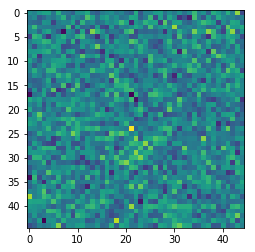

266
1.0


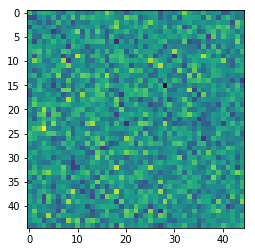

267
0.0


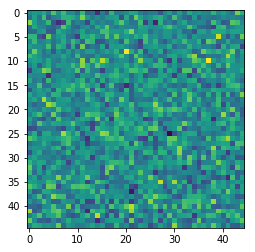

268
1.0


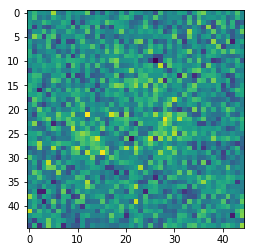

269
0.0


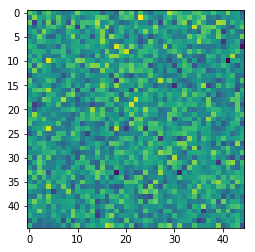

270
1.0


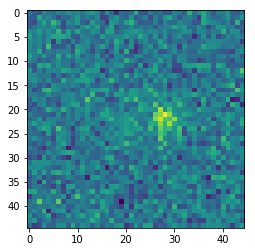

271
1.0


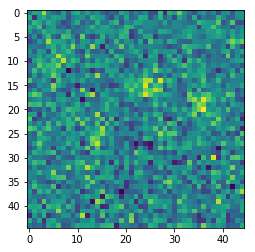

272
1.0


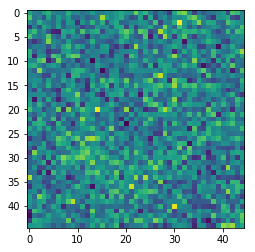

273
0.0


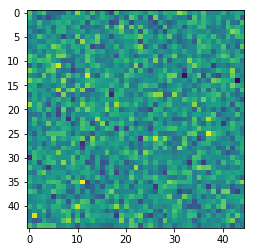

274
0.0


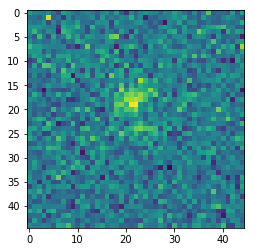

275
1.0


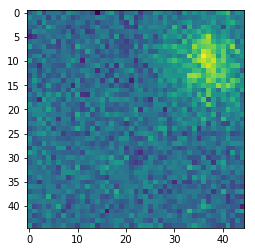

276
0.0


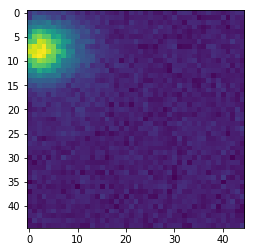

277
1.0


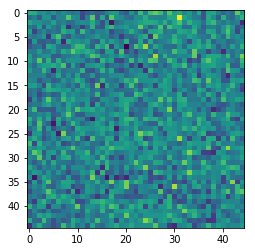

278
1.0


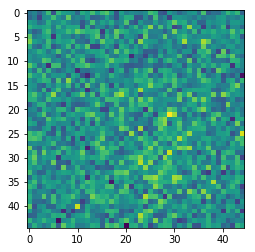

279
1.0


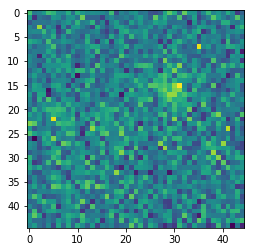

280
1.0


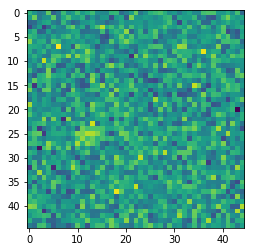

281
1.0


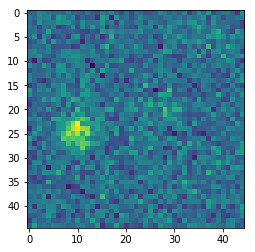

282
0.0


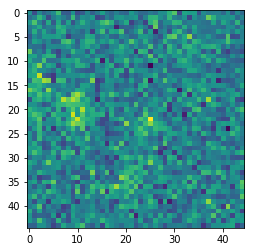

283
1.0


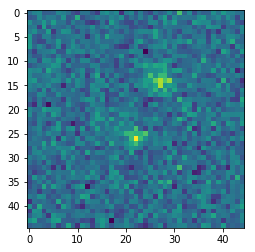

284
0.0


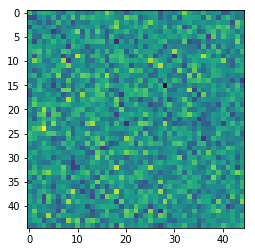

285
1.0


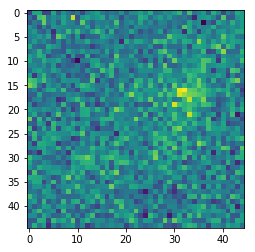

286
0.0


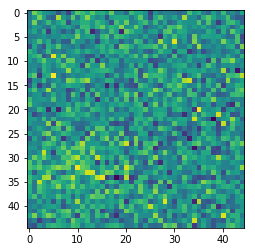

287
1.0


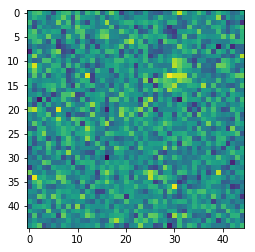

288
1.0


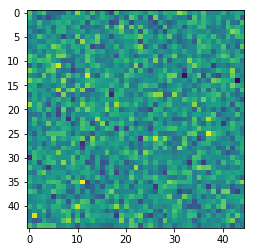

289
0.0


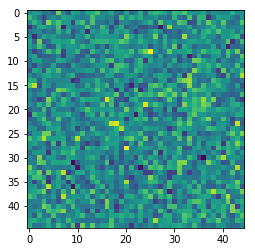

290
1.0


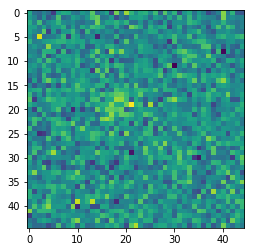

291
1.0


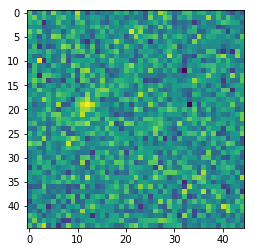

292
1.0


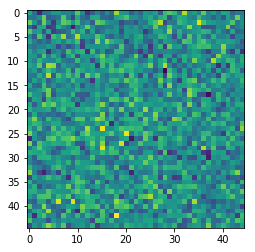

293
1.0


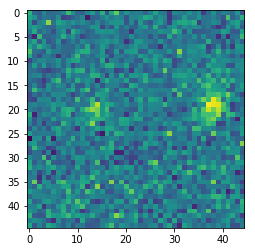

294
0.0


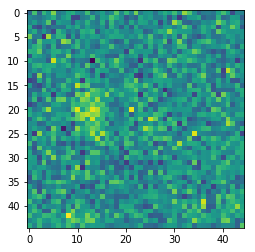

295
0.0


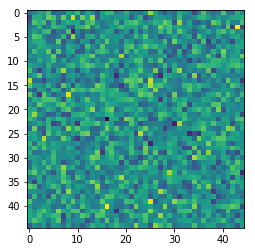

296
0.0


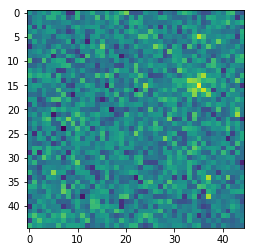

297
0.0


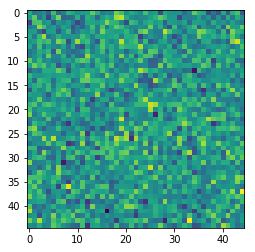

298
1.0


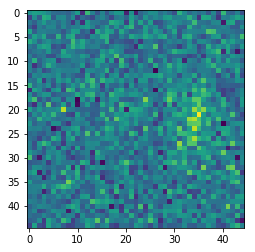

299
0.0


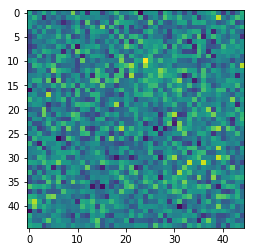

300
0.0


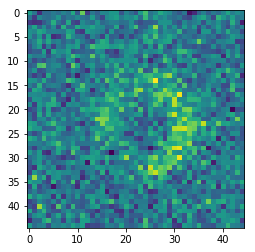

301
1.0


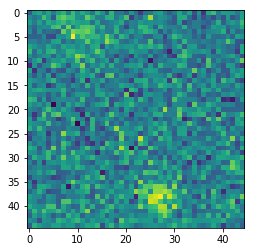

302
1.0


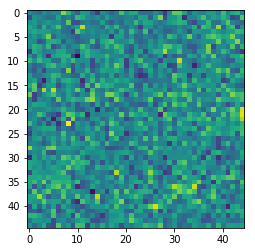

303
0.0


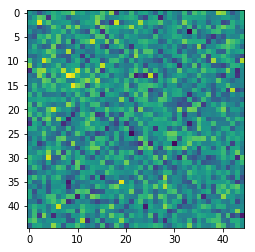

304
1.0


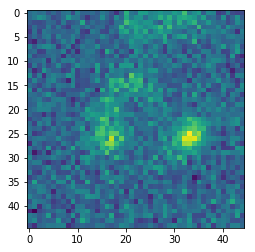

305
1.0


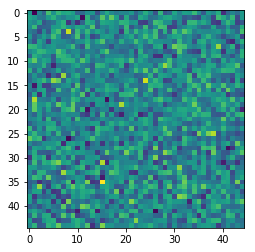

306
1.0


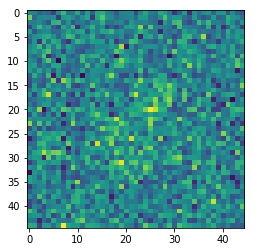

307
0.0


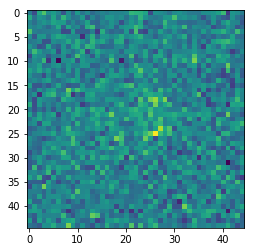

308
0.0


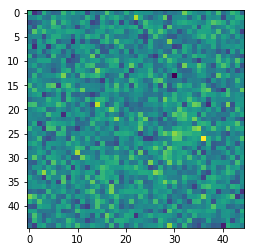

309
0.0


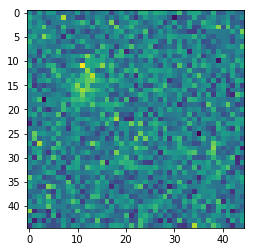

310
1.0


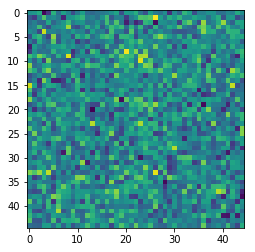

311
1.0


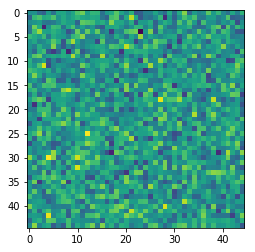

312
0.0


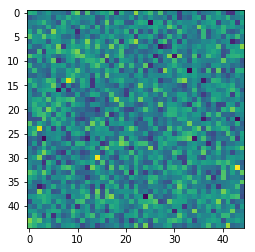

313
1.0


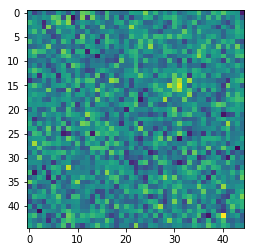

314
1.0


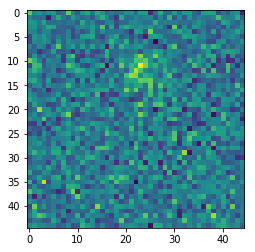

315
0.0


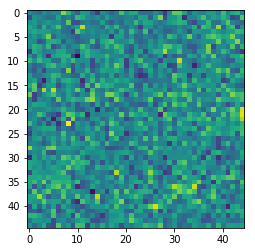

316
0.0


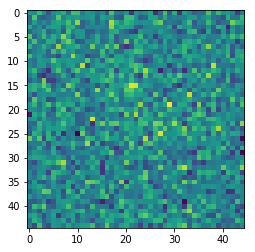

317
1.0


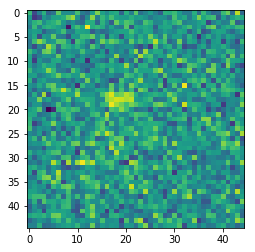

318
0.0


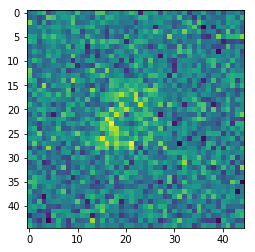

319
0.0


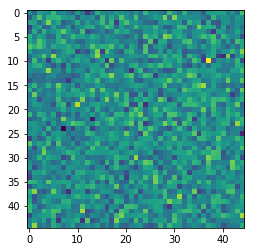

320
1.0


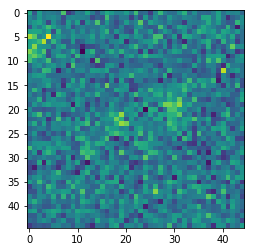

321
0.0


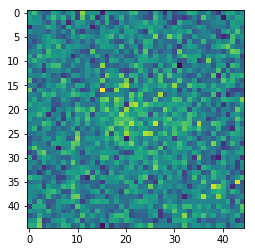

322
1.0


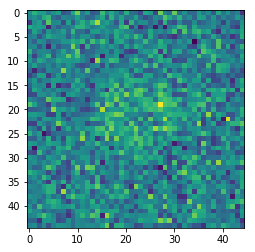

323
0.0


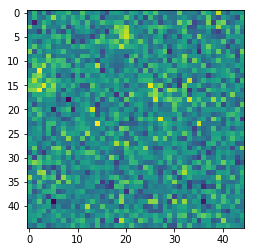

324
1.0


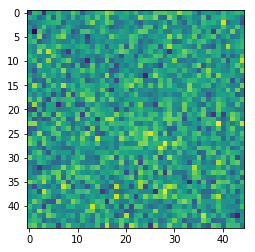

325
1.0


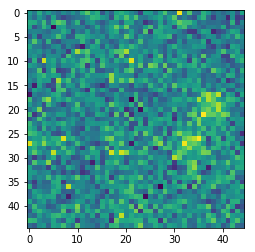

326
0.0


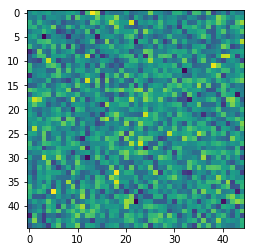

327
0.0


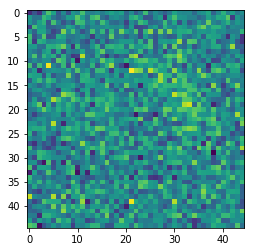

328
0.0


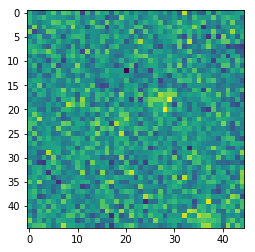

329
0.0


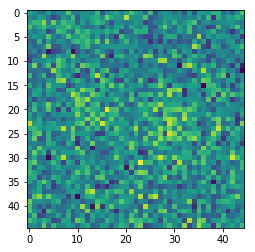

330
1.0


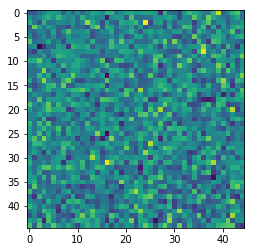

331
1.0


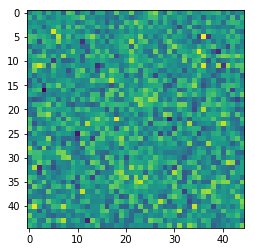

332
0.0


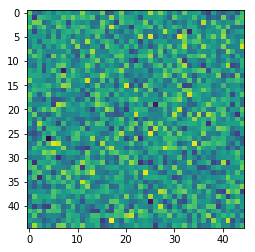

333
1.0


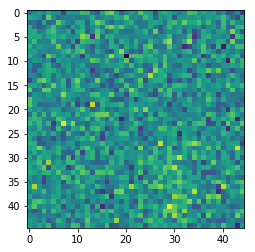

334
1.0


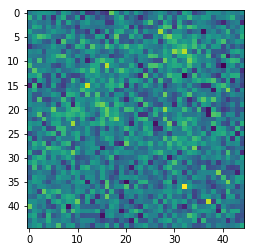

335
1.0


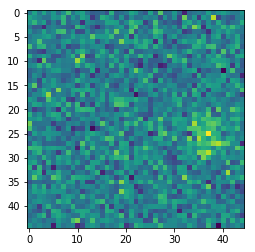

336
1.0


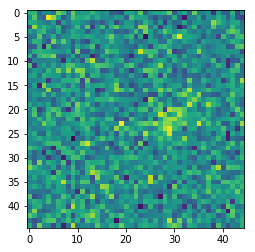

337
0.0


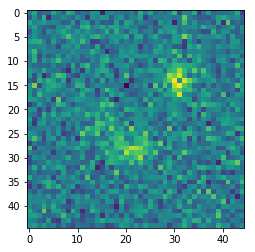

338
1.0


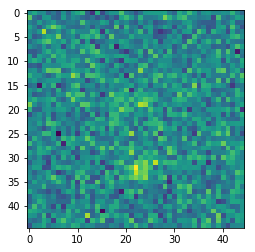

339
0.0


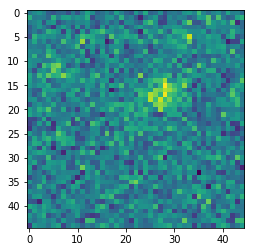

340
1.0


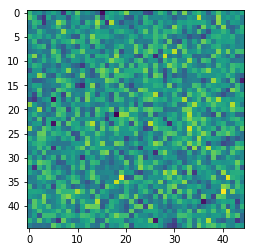

341
0.0


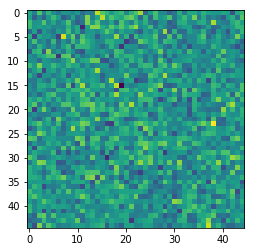

342
1.0


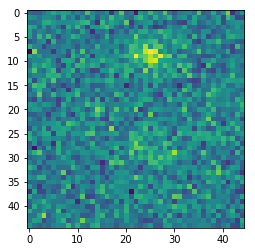

343
0.0


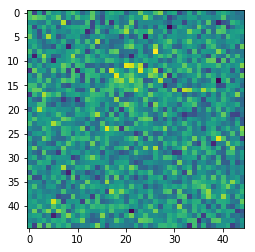

344
1.0


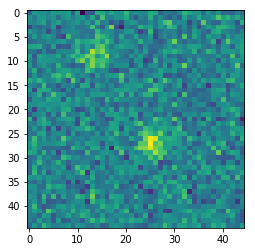

345
0.0


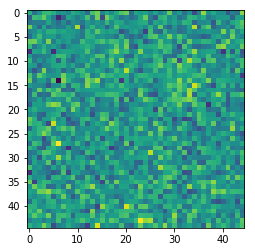

346
0.0


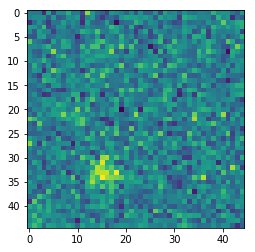

347
0.0


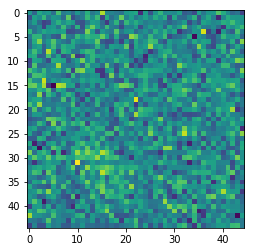

348
1.0


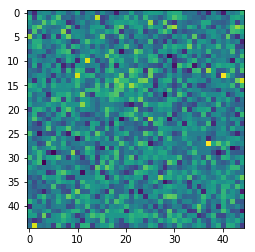

349
1.0


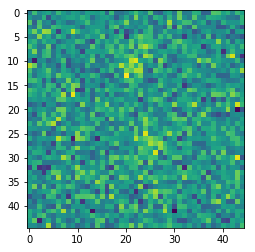

350
1.0


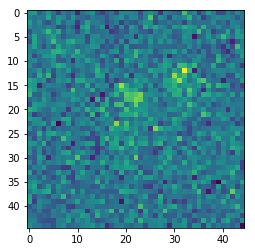

351
0.0


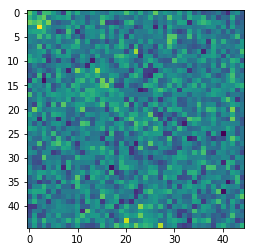

352
1.0


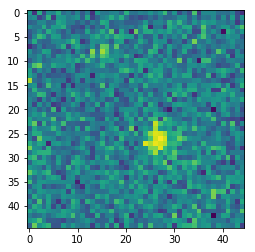

353
1.0


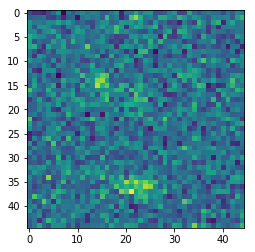

354
0.0


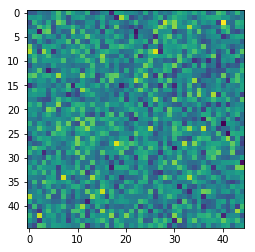

355
1.0


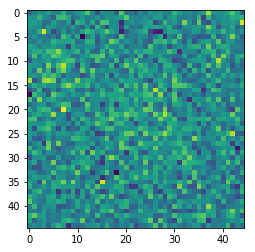

356
0.0


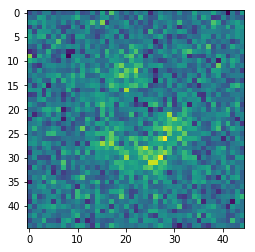

357
1.0


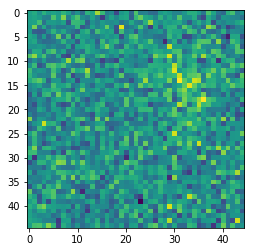

358
0.0


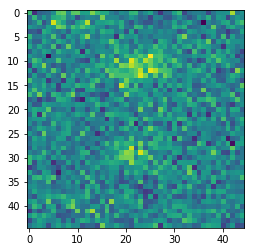

359
1.0


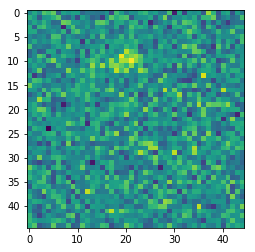

360
0.0


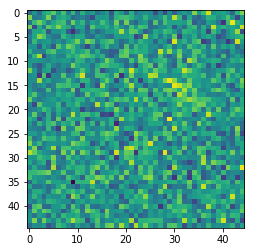

361
0.0


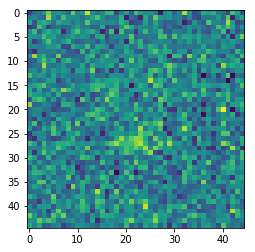

362
0.0


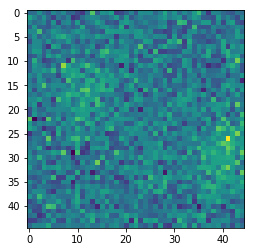

363
0.0


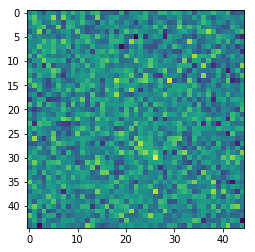

364
1.0


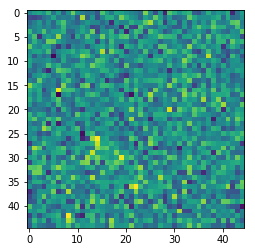

365
1.0


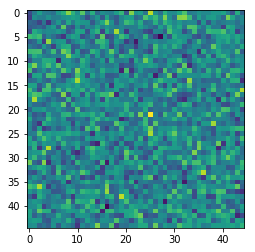

366
0.0


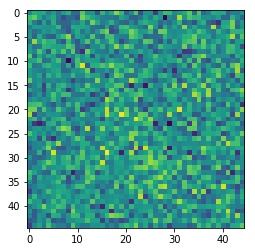

367
0.0


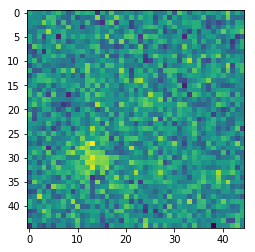

368
0.0


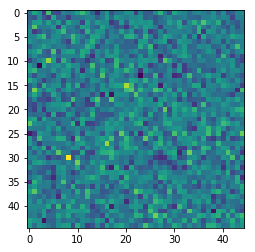

369
0.0


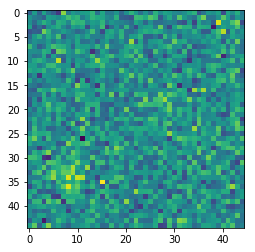

370
1.0


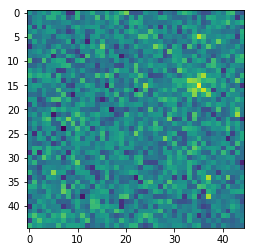

371
0.0


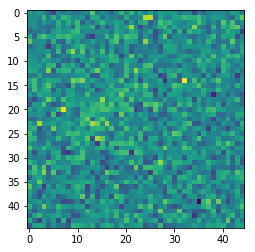

372
0.0


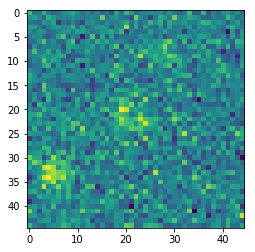

373
1.0


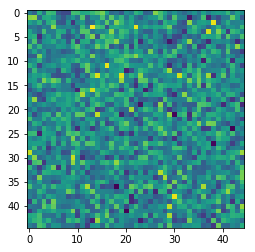

374
1.0


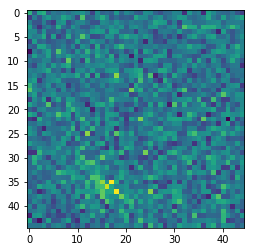

375
0.0


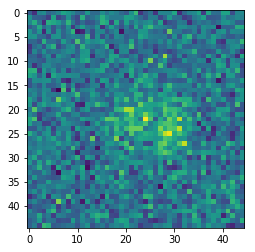

376
1.0


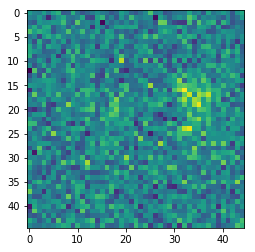

377
1.0


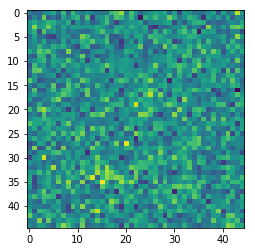

378
1.0


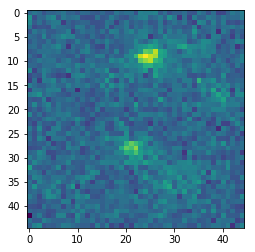

379
0.0


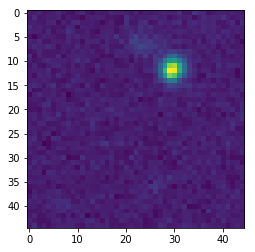

380
1.0


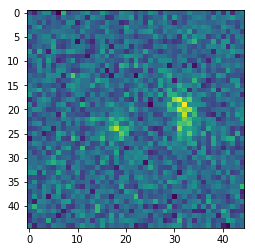

381
1.0


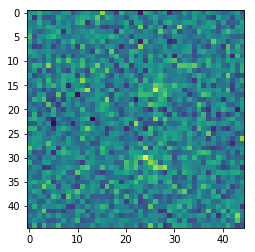

382
1.0


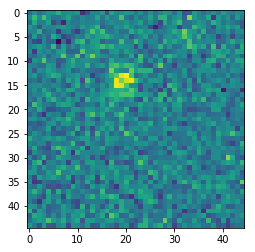

383
0.0


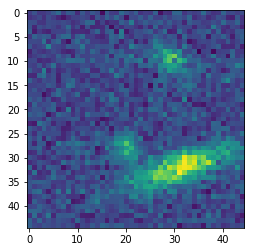

384
1.0


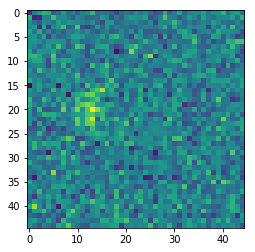

385
1.0


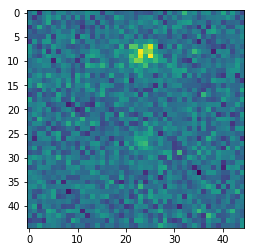

386
1.0


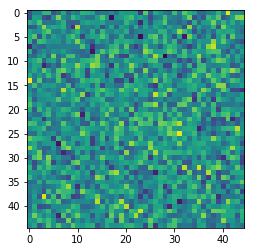

387
0.0


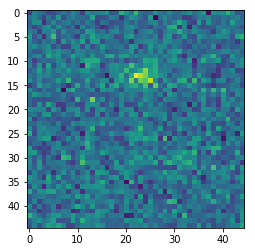

388
0.0


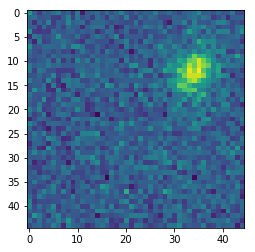

389
0.0


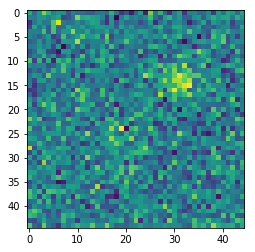

390
0.0


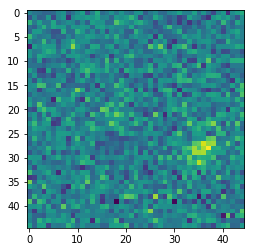

391
0.0


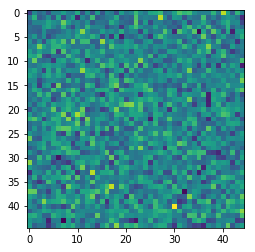

392
0.0


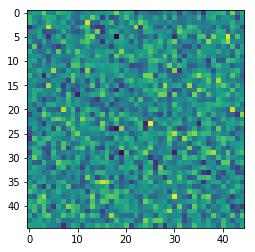

393
1.0


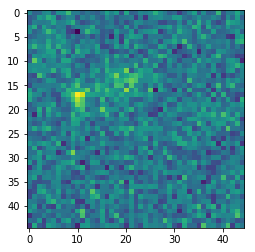

394
0.0


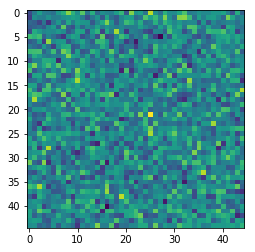

395
1.0


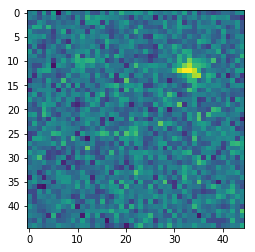

396
0.0


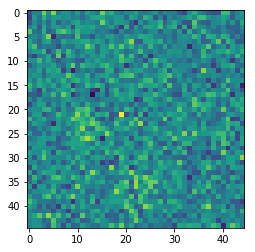

397
0.0


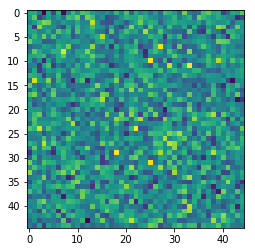

398
0.0


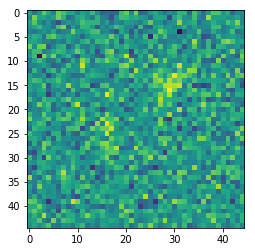

399
0.0


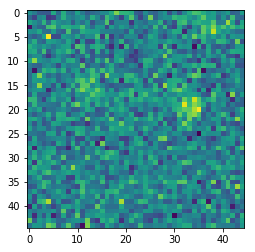

In [41]:
import matplotlib.pyplot as plt
% matplotlib inline
for i in range(len(y_test)):
    print(i)
    print(y_test[i])
    plt.imshow(X_test[i].reshape(45, 45))
    plt.show()

I'm only getting ~50% accuracy. I think this is because some images are extrmely noisy--as we can see in the plots above, the noise may be diluting the sample. The simulations were produced over a variety of signal-to-noise and Einstein radii, which introduces noise that may be contaminating the sample. 

The next step would be to include a filtering method, where I include a threshold that marks whether something is a bad image or not.


'/Users/sarafinanance/Desktop/AST250/final_project'